In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
plt.style.use('mystyle.mplstyle')

## load model

In [2]:
modelpath = 'model/cnn_model'
scalerpath = 'model/std_scaler.bin'

In [4]:
# Load the model and scaler
scaler = load(scalerpath)
model = tf.keras.models.load_model(modelpath)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4875, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1625, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1625, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 541, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 541, 256)          98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 180, 256)         0

## model prediction

In [5]:
datapath = 'data/LAMOST_Gaia_APOGEE_param.csv'  # train & test spectra
parampath = 'data/LAMOST_Gaia_APOGEE.csv'  # params by APOGEE

In [6]:
# load dataset
dataset = pd.read_csv(datapath)
labels = ['teff','logg','feh','mg_geo','bp_rp_0']
X = dataset.iloc[:,7:4882]
y = dataset.loc[:,labels]
obsid = dataset.loc[:,'obsid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
obsid_train, obsid_test = train_test_split(obsid, test_size = 0.2, random_state = 42, shuffle = True)
y_test = scaler.transform(y_test)

# Reshape train and test data to (n_samples, 187, 1), where each sample is of size (187, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = np.array(y_train).reshape(y_train.shape[0], y_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1])
print("reshape X_train: ", X_train.shape,"reshape y_train: ", y_train.shape)
print("reshape X_test: ", X_test.shape,"reshape y_test: ", y_test.shape)

reshape X_train:  (14858, 4875, 1) reshape y_train:  (14858, 5)
reshape X_test:  (3715, 4875, 1) reshape y_test:  (3715, 5)


In [8]:
prediction = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)))
prediction.columns = ['pre_teff','pre_logg','pre_feh','pre_mg_geo','pre_bp_rp_0']

obsid_test = obsid_test.reset_index(drop=True)
prediction['obsid'] = obsid_test

param_apogee = pd.read_csv(parampath)
test = prediction.merge(param_apogee,how='left',on='obsid')

117/117 [==============================] - 3s 29ms/step


## calculate distance

In [9]:
ori_teff = test['TEFF_1']
ori_logg = test['LOGG_1']
ori_feh = test['FE_H']
x_label = ['$T_{\\rm{eff}}$'+' $_{\\rm{APOGEE}}$ [K]',
           '$\\log {g}$'+' $_{\\rm{APOGEE}}$ [dex]',
           '[Fe/H] $_{\\rm{APOGEE}}$ [dex]',
           '$M_{\\rm{G}}$ [mag]',
           '$\\rm{({BP}-{RP})_{0}}$ [mag]',
           '$d_{\\rm{geo}}$ [pc]']
y_label = ['$T_{\\rm{eff}}$'+' $_{\\rm{CNN}}$',
           '$\\log {g}$'+' $_{\\rm{CNN}}$',
           '[Fe/H] $_{\\rm{CNN}}$',
           '$M_{\\rm{G}}$'+' $_{\\rm{CNN}}$',
           '$\\rm{({BP}-{RP})_{0}}$'+' $_{\\rm{CNN}}$',
           '$d_{\\rm{geo}}$'+' $_{\\rm{CNN}}$']
ori_mg = test['mg_geo']
ori_bprp0 = test['bp_rp_0']

pre_labels = ['pre_teff','pre_logg','pre_feh','pre_mg_geo','pre_bp_rp_0']
pre_teff = test[pre_labels[0]]
pre_logg = test[pre_labels[1]]
pre_feh = test[pre_labels[2]]
pre_mg = test[pre_labels[3]]
pre_bprp0 = test[pre_labels[4]]

resid_teff = ori_teff - pre_teff
resid_logg = ori_logg - pre_logg
resid_feh = ori_feh - pre_feh
resid_mg = ori_mg - pre_mg
resid_bprp0 = ori_bprp0 - pre_bprp0

mu_teff, sigma_teff = np.mean(ori_teff - pre_teff), np.std(ori_teff - pre_teff)
mu_logg, sigma_logg = np.mean(ori_logg - pre_logg), np.std(ori_logg - pre_logg)
mu_feh, sigma_feh = np.mean(ori_feh - pre_feh), np.std(ori_feh - pre_feh)
mu_mg, sigma_mg = np.mean(ori_mg - pre_mg), np.std(ori_mg - pre_mg)
mu_bprp0, sigma_bprp0 = np.mean(ori_bprp0 - pre_bprp0), np.std(ori_bprp0 - pre_bprp0)

lim_teff = (min(min(ori_teff),min(pre_teff))-20, max(max(ori_teff),max(pre_teff))+20)
lim_logg = (min(min(ori_logg),min(pre_logg)), max(max(ori_logg),max(pre_logg)))
lim_feh = (min(min(ori_feh),min(pre_feh)), max(max(ori_feh),max(pre_feh)))
lim_mg = (min(min(ori_mg),min(pre_mg)), max(max(ori_mg),max(pre_mg)))
lim_bprp0 = (min(min(ori_bprp0),min(pre_bprp0)), max(max(ori_bprp0),max(pre_bprp0)))

In [10]:
from scipy.optimize import minimize_scalar
# Calculate distance d from the predicted absolute magnitude M
# Assume the absolute magnitude M follows a normal distribution M ~ N(mu, sigma)
def p_M(M,mu,sigma):
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(M-mu)**2 / (2*(sigma**2)))

def p_d(d,m,mu_M,sigma_M,A):
    return np.abs(5/(d*np.log(10))) * p_M(M = m-5*np.log10(d)+5-A,mu = mu_M,sigma = sigma_M)

def neg_p_d(d, m, mu_M, sigma_M, A):
    return -p_d(d, m, mu_M, sigma_M, A)

m = test['gaia_g_mean_mag']
mu_M = test['pre_mg_geo']
sigma_M = sigma_mg
test['cnn1_av'] = (test['bp_rp'] - test['pre_bp_rp_0']) / (1.08337-0.63439)
test['cnn1_ag'] = 0.83627 * (test['bp_rp'] - test['pre_bp_rp_0']) / (1.08337-0.63439)
A = test['cnn1_ag']
print(sigma_M)


d_max_values = []
for m_i, mu_M_i, A_i in zip(m, mu_M, A):
    result = minimize_scalar(neg_p_d, args=(m_i, mu_M_i, sigma_M, A_i), bounds=(0, 1e4), method='bounded')
    d_max_values.append(result.x)

print("distance: ", d_max_values)

test['pre_d_med'] = d_max_values
# test['direct_d'] = 10 ** ((5-test['azero_gspphot']+test['gaia_g_mean_mag']-test['pre_mg_geo']) / 5)
# test['direct_d'] = 10 ** ((5-test['cnn1_ag']+test['gaia_g_mean_mag']-test['pre_mg_geo']) / 5)

0.25464918408761095
distance:  [166.29392102026995, 421.66054216729157, 474.371827047104, 268.2689236276857, 440.5962686286659, 208.80248703193374, 372.9093023402987, 872.6653026772037, 312.13503202658785, 312.5204619918473, 449.81580924592896, 836.985968463036, 397.9382793036637, 467.2557793853942, 431.3077595839198, 340.2838383095715, 479.4298769985031, 210.76555083576707, 170.55805414671687, 927.4149384768592, 512.8712648035306, 200.68489799088744, 303.23253455158994, 331.6818709705676, 444.24533542192995, 249.6389136488346, 423.88768536033155, 494.6719448864317, 506.0324251549444, 566.8590415482885, 542.8070307007127, 320.9694209091049, 323.99792088243794, 263.5831181085626, 273.953589560462, 779.2717759491738, 288.08716651080766, 298.82834386714046, 275.11042546654403, 656.2907711668086, 380.89171714260294, 334.7685356605004, 371.1018033375297, 210.82389356292995, 441.2461320951162, 577.2180307948552, 326.29854393369305, 543.1764624644557, 191.64777481855626, 881.0385854909792, 22

## Model Performence

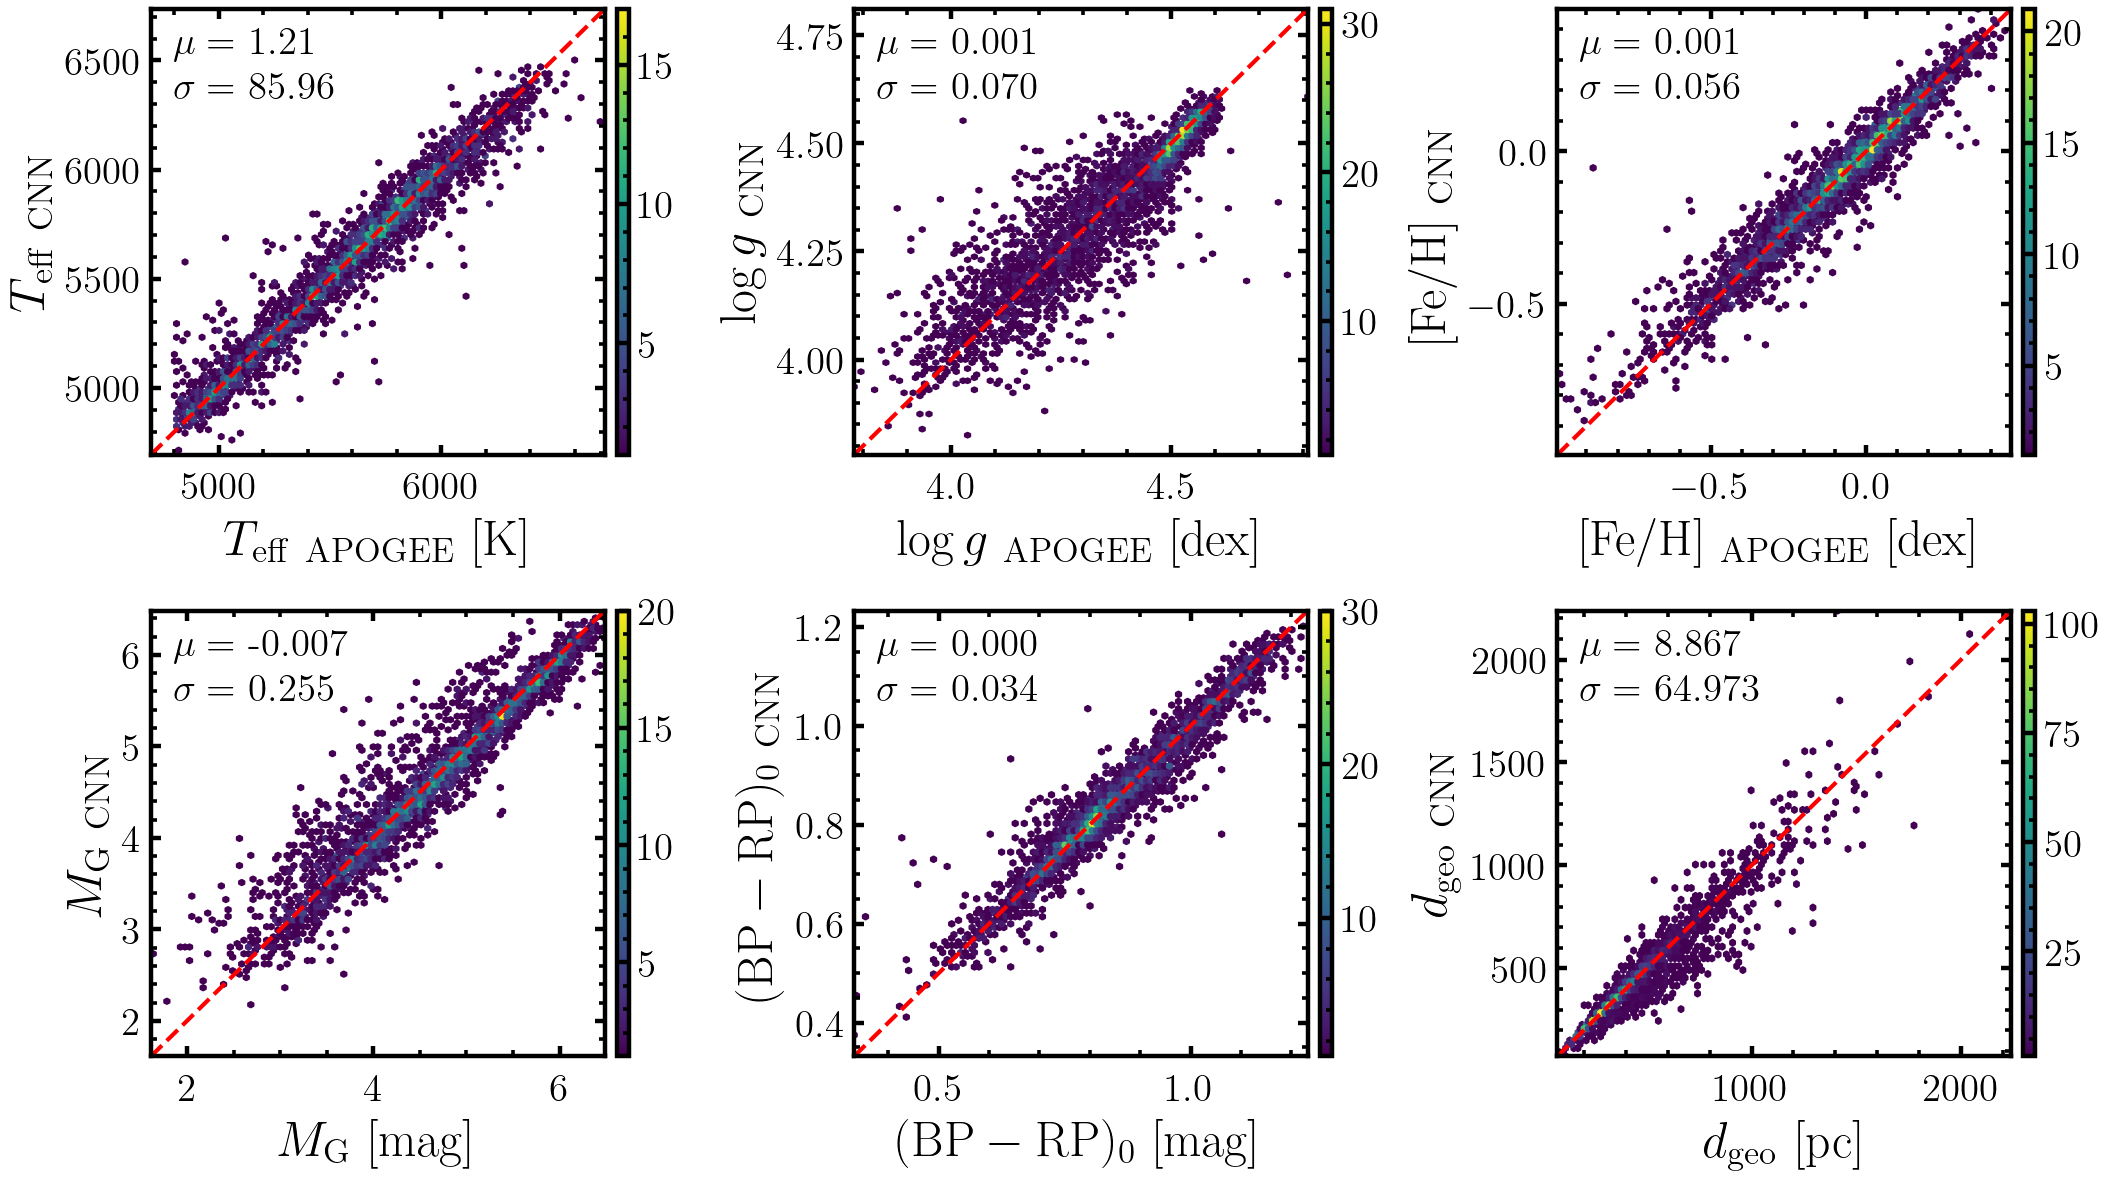

In [11]:
# prediction results
def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)
    return cax

fig = plt.figure(figsize=(12, 6.8), dpi=200)
gs = GridSpec(2, 3, figure=fig, wspace=0.55, hspace=0.35)
fontdict = {'size':14, 'color':'k', 'family':'serif'}

def subplot(gsx,gsy,datax,datay,labelnum,lim,datamu,datasigma,fnum):
    ax = fig.add_subplot(gs[gsx,gsy])
    hb = ax.hexbin(datax,datay,gridsize=100,mincnt=1, cmap='viridis')
    # 设置的colorbar
    cax = add_right_cax(ax, pad=0.005, width=0.005)
    cb = fig.colorbar(hb, cax=cax)
    # cb.ax.set_title('Count')
    ax.plot([0,1],[0,1],transform=ax.transAxes, ls='--',c='r')
    ax.set_xlabel(x_label[labelnum])
    ax.set_ylabel(y_label[labelnum])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    if fnum == 2: 
        ax.text(0.05,0.9,'$\mu=\ $'+'%.2f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
        ax.text(0.05,0.8,'$\sigma=\ $'+'%.2f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)
    elif fnum == 3:
        ax.text(0.05,0.9,'$\mu=\ $'+'%.3f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
        ax.text(0.05,0.8,'$\sigma=\ $'+'%.3f'%(datasigma),transform=ax.transAxes,fontdict=fontdict, color='k')        
    return 

subplot(gsx=0, gsy=0, datax=ori_teff, datay=pre_teff, labelnum=0, lim=lim_teff, datamu=mu_teff, datasigma=sigma_teff, fnum=2)
subplot(gsx=0, gsy=1, datax=ori_logg, datay=pre_logg, labelnum=1, lim=lim_logg, datamu=mu_logg, datasigma=sigma_logg, fnum=3)
subplot(gsx=0, gsy=2, datax=ori_feh, datay=pre_feh, labelnum=2, lim=lim_feh, datamu=mu_feh, datasigma=sigma_feh, fnum=3)
subplot(gsx=1, gsy=0, datax=ori_mg, datay=pre_mg, labelnum=3, lim=lim_mg, datamu=mu_mg, datasigma=sigma_mg, fnum=3)
subplot(gsx=1, gsy=1, datax=ori_bprp0, datay=pre_bprp0, labelnum=4, lim=lim_bprp0, datamu=mu_bprp0, datasigma=sigma_bprp0, fnum=3)

ori_d = test['r_med_geo']
pre_d = test['pre_d_med']
resid_d = ori_d - pre_d
mu_d, sigma_d = np.mean(ori_d - pre_d), np.std(ori_d - pre_d)
lim_d = (min(min(ori_d),min(pre_d)), max(max(ori_d),max(pre_d)))
subplot(gsx=1, gsy=2, datax=ori_d, datay=pre_d, labelnum=5, lim=lim_d, datamu=mu_d, datasigma=sigma_d, fnum=3)

3715 2795 920


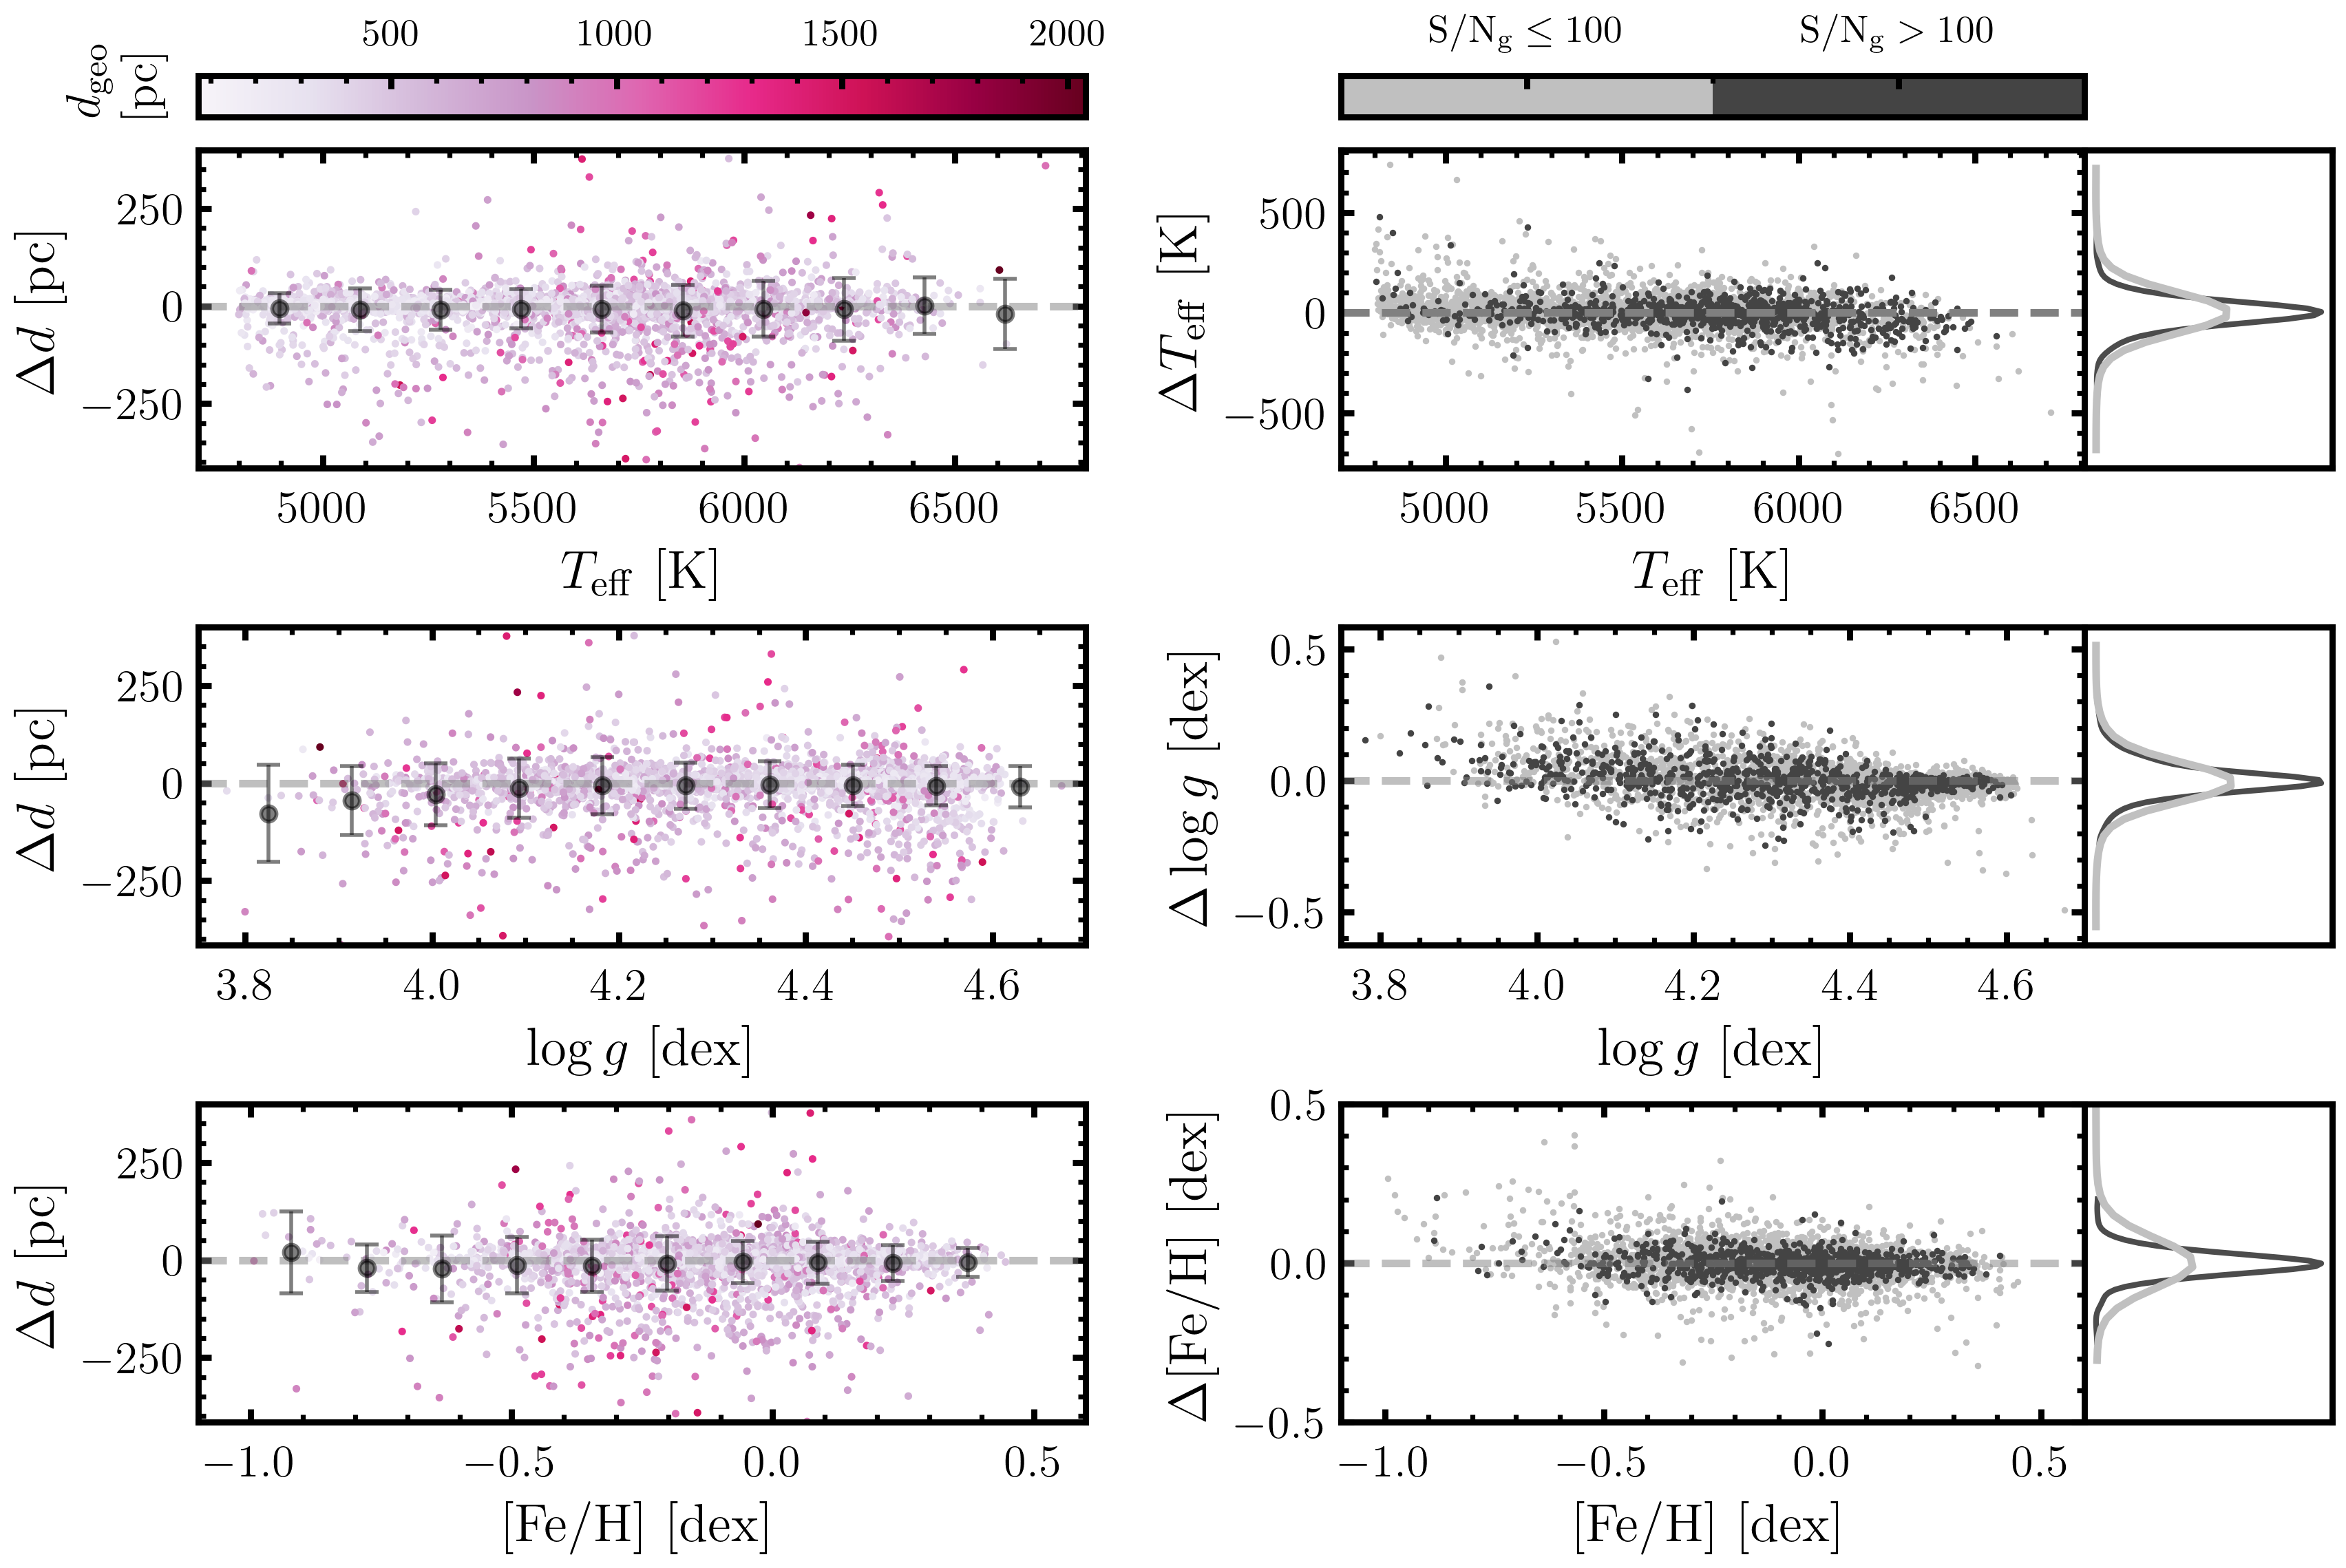

In [14]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def add_top_cax(ax, pad, width):
    '''
    在一个ax上边追加与之等宽的cax.
    pad是cax与ax的间距,
    width是cax的高度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x0,
        axpos.y1 + pad,
        axpos.x1,
        axpos.y1 + pad + width
    )
    cax = ax.figure.add_axes(caxpos)
    return cax


resid_d = pre_d - ori_d
# resid_d = resid_d_full / ori_d
snr = test['snrg']
resid_teff = pre_teff - ori_teff
resid_logg = pre_logg - ori_logg
resid_feh = pre_feh - ori_feh

# ! snr cut
cut = 100
print(len(test), len(test[test['snrg']<=cut]), len(test[test['snrg']>cut]))
lowsnr = test['snrg']<=cut
highsnr = test['snrg']>cut

rd_min, rd_max = -415, 400

# draw figure
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = GridSpec(3, 7, figure=fig, hspace=0.5, wspace=0.18)

# column one
ax1 = fig.add_subplot(gs[0, 0:3])
sc1 = ax1.scatter(ori_teff, resid_d, s=1, c=ori_d, cmap='PuRd')
ax1.axhline(y=0, color='grey', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_ylim(rd_min, rd_max)
cax1 = add_top_cax(ax1, pad=0.02, width=0.025)
cbar1 = fig.colorbar(sc1, cax=cax1, location='top')
# cbar.set_label(label='$d_{\\rm{geo}}$', fontsize=12, loc='left')
cbar1.ax.set_ylabel('$d_{\\rm{geo}}$' + '\n [pc]', fontsize=12.5, loc='bottom',labelpad=8)
cbar1.ax.tick_params(labelsize=10)
# 分bin散点
ax1_numbins = 10
ax1_id = (resid_d>rd_min) & (resid_d<rd_max)
ax1_bins = np.linspace(np.min(ori_teff[ax1_id]), np.max(ori_teff[ax1_id]), ax1_numbins+1)
# 计算每个bin中y的均值和标准差
ax1_bincs = []
ax1_ymeans = []
ax1_ystds = []
for i in range(ax1_numbins):
    bin_mask = (ori_teff[ax1_id] >= ax1_bins[i]) & (ori_teff[ax1_id] < ax1_bins[i+1])
    aux_binc = (ax1_bins[i] + ax1_bins[i+1]) / 2
    y_in_bin = resid_d[ax1_id][bin_mask]
    if len(y_in_bin) > 0:
        aux_mean = np.mean(y_in_bin)
        aux_std = np.std(y_in_bin)
    else:
        aux_mean = np.nan
        aux_std = np.nan
    ax1_bincs.append(aux_binc)
    ax1_ymeans.append(aux_mean)
    ax1_ystds.append(aux_std)
ax1.errorbar(ax1_bincs, ax1_ymeans, yerr=ax1_ystds, fmt='o', color='k', alpha=0.5, markersize=4, capsize=3, capthick=1, elinewidth=1)

ax2 = fig.add_subplot(gs[1, 0:3])
sc2 = ax2.scatter(ori_logg, resid_d, s=1, c=ori_d, cmap='PuRd')
ax2.axhline(y=0, color='grey', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_ylim(rd_min, rd_max)
ax2.set_xlim(3.75, 4.7)
# 分bin散点
ax2_numbins = 10
ax2_id = (resid_d>rd_min) & (resid_d<rd_max) & (ori_logg>3.75) & (ori_logg<4.7)
ax2_bins = np.linspace(np.min(ori_logg[ax2_id]), np.max(ori_logg[ax2_id]), ax2_numbins+1)
# 计算每个bin中y的均值和标准差
ax2_bincs = []
ax2_ymeans = []
ax2_ystds = []
for i in range(ax2_numbins):
    bin_mask = (ori_logg[ax2_id] >= ax2_bins[i]) & (ori_logg[ax2_id] < ax2_bins[i+1])
    aux_binc = (ax2_bins[i] + ax2_bins[i+1]) / 2
    y_in_bin = resid_d[ax2_id][bin_mask]
    if len(y_in_bin) > 0:
        aux_mean = np.mean(y_in_bin)
        aux_std = np.std(y_in_bin)
    else:
        aux_mean = np.nan
        aux_std = np.nan
    ax2_bincs.append(aux_binc)
    ax2_ymeans.append(aux_mean)
    ax2_ystds.append(aux_std)
ax2.errorbar(ax2_bincs, ax2_ymeans, yerr=ax2_ystds, fmt='o', color='k',alpha=0.5, markersize=4, capsize=3, capthick=1, elinewidth=1)

ax3 = fig.add_subplot(gs[2, 0:3])
sc3 = ax3.scatter(ori_feh, resid_d, s=1, c=ori_d, cmap='PuRd')
ax3.axhline(y=0, color='grey', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_ylim(rd_min, rd_max)
ax3.set_xlim(-1.1, 0.6)
# 分bin散点
ax3_numbins = 10
ax3_id = (resid_d>rd_min) & (resid_d<rd_max) & (ori_feh>-1.1) & (ori_feh<0.6)
ax3_bins = np.linspace(np.min(ori_feh[ax3_id]), np.max(ori_feh[ax3_id]), ax3_numbins+1)
# 计算每个bin中y的均值和标准差
ax3_bincs = []
ax3_ymeans = []
ax3_ystds = []
for i in range(ax3_numbins):
    bin_mask = (ori_feh[ax3_id] >= ax3_bins[i]) & (ori_feh[ax3_id] < ax3_bins[i+1])
    aux_binc = (ax3_bins[i] + ax3_bins[i+1]) / 2
    y_in_bin = resid_d[ax3_id][bin_mask]
    if len(y_in_bin) > 0:
        aux_mean = np.mean(y_in_bin)
        aux_std = np.std(y_in_bin)
    else:
        aux_mean = np.nan
        aux_std = np.nan
    ax3_bincs.append(aux_binc)
    ax3_ymeans.append(aux_mean)
    ax3_ystds.append(aux_std)
ax3.errorbar(ax3_bincs, ax3_ymeans, yerr=ax3_ystds, fmt='o', color='k', alpha=0.5, markersize=4, capsize=3, capthick=1, elinewidth=1)

# 第二列和第三列子图使用单独的 GridSpec
gs_right = GridSpec(3, 4, figure=fig, hspace=0.5, wspace=0.0, left=0.54, right=0.9)
# column two
ax12 = fig.add_subplot(gs_right[0, 0:3], sharex=ax1)
ax12.scatter(ori_teff[lowsnr], resid_teff[lowsnr], s=0.5, c='silver')
ax12.scatter(ori_teff[highsnr], resid_teff[highsnr], s=0.5, c='#444444')
ax12.axhline(y=0, color='grey', linestyle='--', linewidth=2)
# 创建自定义的colormap
cmap_my = mcolors.ListedColormap(['silver', '#444444'])
bounds = [0, 1, 2]
norm = mcolors.BoundaryNorm(bounds, cmap_my.N)
sm = cm.ScalarMappable(cmap=cmap_my, norm=norm)
sm.set_array([])
# 添加colorbar
cax2 = add_top_cax(ax12, pad=0.02, width=0.025)
cbar2 = plt.colorbar(sm, cax=cax2, location='top', ticks=[0.5, 1.5])
cbar2.ax.set_xticklabels(['$\\rm{S/N_{g}} \leq 100$', '$\\rm{S/N_{g}}>100$'],size=10)  # 设置colorbar的标签

ax22 = fig.add_subplot(gs_right[1, 0:3], sharex=ax2)
ax22.scatter(ori_logg[lowsnr], resid_logg[lowsnr], s=0.5, c='silver')
ax22.scatter(ori_logg[highsnr], resid_logg[highsnr], s=0.5, c='#444444')
ax22.axhline(y=0, color='grey', linestyle='--', linewidth=2, alpha=0.5)

ax32 = fig.add_subplot(gs_right[2, 0:3], sharex=ax3)
ax32.scatter(ori_feh[lowsnr], resid_feh[lowsnr], s=0.5, c='silver')
ax32.scatter(ori_feh[highsnr], resid_feh[highsnr], s=0.5, c='#444444')
ax32.axhline(y=0, color='grey', linestyle='--', linewidth=2, alpha=0.5)
ax32.set_ylim(-0.5, 0.5)

# column three
from scipy.ndimage import gaussian_filter1d
sigma = 2
bins=50
lowbins = 35
lowsnr2 = test['snrg']<=100

ax13 = fig.add_subplot(gs_right[0, 3], sharey=ax12)
hist_y_low, bin_ye_low = np.histogram(resid_teff[lowsnr2], bins=lowbins)
norm_y_low = hist_y_low / ((np.sum(hist_y_low)) * (bin_ye_low[1]-bin_ye_low[0]))
snorm_y_low = gaussian_filter1d(norm_y_low, sigma)
bin_yc_low = (bin_ye_low[:-1] + bin_ye_low[1:]) / 2
hist_y_high, bin_ye_high = np.histogram(resid_teff[highsnr], bins=bins)
norm_y_high = hist_y_high / ((np.sum(hist_y_high)) * (bin_ye_high[1]-bin_ye_high[0]))
snorm_y_high = gaussian_filter1d(norm_y_high, sigma)
bin_yc_high = (bin_ye_high[:-1] + bin_ye_high[1:]) / 2
ax13.plot(snorm_y_high, bin_yc_high, c='black', alpha=0.7, lw=1.5)
ax13.plot(snorm_y_low, bin_yc_low, c='silver', lw=2)
ax13.yaxis.set_visible(False)
ax13.xaxis.set_visible(False)

ax23 = fig.add_subplot(gs_right[1, 3], sharey=ax22)
hist_y_low, bin_ye_low = np.histogram(resid_logg[lowsnr2], bins=lowbins)
norm_y_low = hist_y_low / (np.sum(hist_y_low) * (bin_ye_low[1]-bin_ye_low[0]))
snorm_y_low = gaussian_filter1d(norm_y_low, sigma)
bin_yc_low = (bin_ye_low[:-1] + bin_ye_low[1:]) / 2
hist_y_high, bin_ye_high = np.histogram(resid_logg[highsnr], bins=bins)
norm_y_high = hist_y_high / (np.sum(hist_y_high) * (bin_ye_high[1]-bin_ye_high[0]))
snorm_y_high = gaussian_filter1d(norm_y_high, sigma)
bin_yc_high = (bin_ye_high[:-1] + bin_ye_high[1:]) / 2
ax23.plot(snorm_y_high, bin_yc_high, c='black', alpha=0.7, lw=1.5)
ax23.plot(snorm_y_low, bin_yc_low, c='silver', lw=2)
ax23.yaxis.set_visible(False)
ax23.xaxis.set_visible(False)

ax33 = fig.add_subplot(gs_right[2, 3],  sharey=ax32)
hist_y_low, bin_ye_low = np.histogram(resid_feh[lowsnr2], bins=lowbins)
norm_y_low = hist_y_low / (np.sum(hist_y_low) * (bin_ye_low[1]-bin_ye_low[0]))
snorm_y_low = gaussian_filter1d(norm_y_low, sigma)
bin_yc_low = (bin_ye_low[:-1] + bin_ye_low[1:]) / 2
hist_y_high, bin_ye_high = np.histogram(resid_feh[highsnr], bins=bins)
norm_y_high = hist_y_high / (np.sum(hist_y_high) * (bin_ye_high[1]-bin_ye_high[0]))
snorm_y_high = gaussian_filter1d(norm_y_high, sigma)
bin_yc_high = (bin_ye_high[:-1] + bin_ye_high[1:]) / 2
ax33.plot(snorm_y_high, bin_yc_high, c='black', alpha=0.7,lw=1.5)
ax33.plot(snorm_y_low, bin_yc_low, c='silver', lw=2)
ax33.yaxis.set_visible(False)
ax33.xaxis.set_visible(False)

labelsize=14
ylabel_col1 = '$\Delta d$' + ' [pc]'
ax1.set_ylabel(ylabel_col1, fontsize=labelsize)
ax2.set_ylabel(ylabel_col1, fontsize=labelsize)
ax3.set_ylabel(ylabel_col1, fontsize=labelsize)
ax12.set_ylabel('$\Delta T_{\\rm{eff}}$' + ' [K]', fontsize=labelsize)
ax22.set_ylabel('$\Delta \log {g}$' + ' [dex]', fontsize=labelsize)
ax32.set_ylabel('$\Delta \\rm{[Fe/H]}$' + ' [dex]', fontsize=labelsize)

xlabel_row1 = '$T_{\\rm{eff}}$' + ' [K]'
xlabel_row2 = '$\log {g}$' + ' [dex]'
xlabel_row3 = '$\\rm{[Fe/H]}$' + ' [dex]'
ax1.set_xlabel(xlabel_row1, fontsize=labelsize)
ax12.set_xlabel(xlabel_row1, fontsize=labelsize)
ax2.set_xlabel(xlabel_row2, fontsize=labelsize)
ax22.set_xlabel(xlabel_row2, fontsize=labelsize)
ax3.set_xlabel(xlabel_row3, fontsize=labelsize)
ax32.set_xlabel(xlabel_row3, fontsize=labelsize)

ticksize = 12
ax1.tick_params(labelsize=ticksize)
ax2.tick_params(labelsize=ticksize)
ax3.tick_params(labelsize=ticksize)
ax12.tick_params(labelsize=ticksize)
ax22.tick_params(labelsize=ticksize)
ax32.tick_params(labelsize=ticksize)

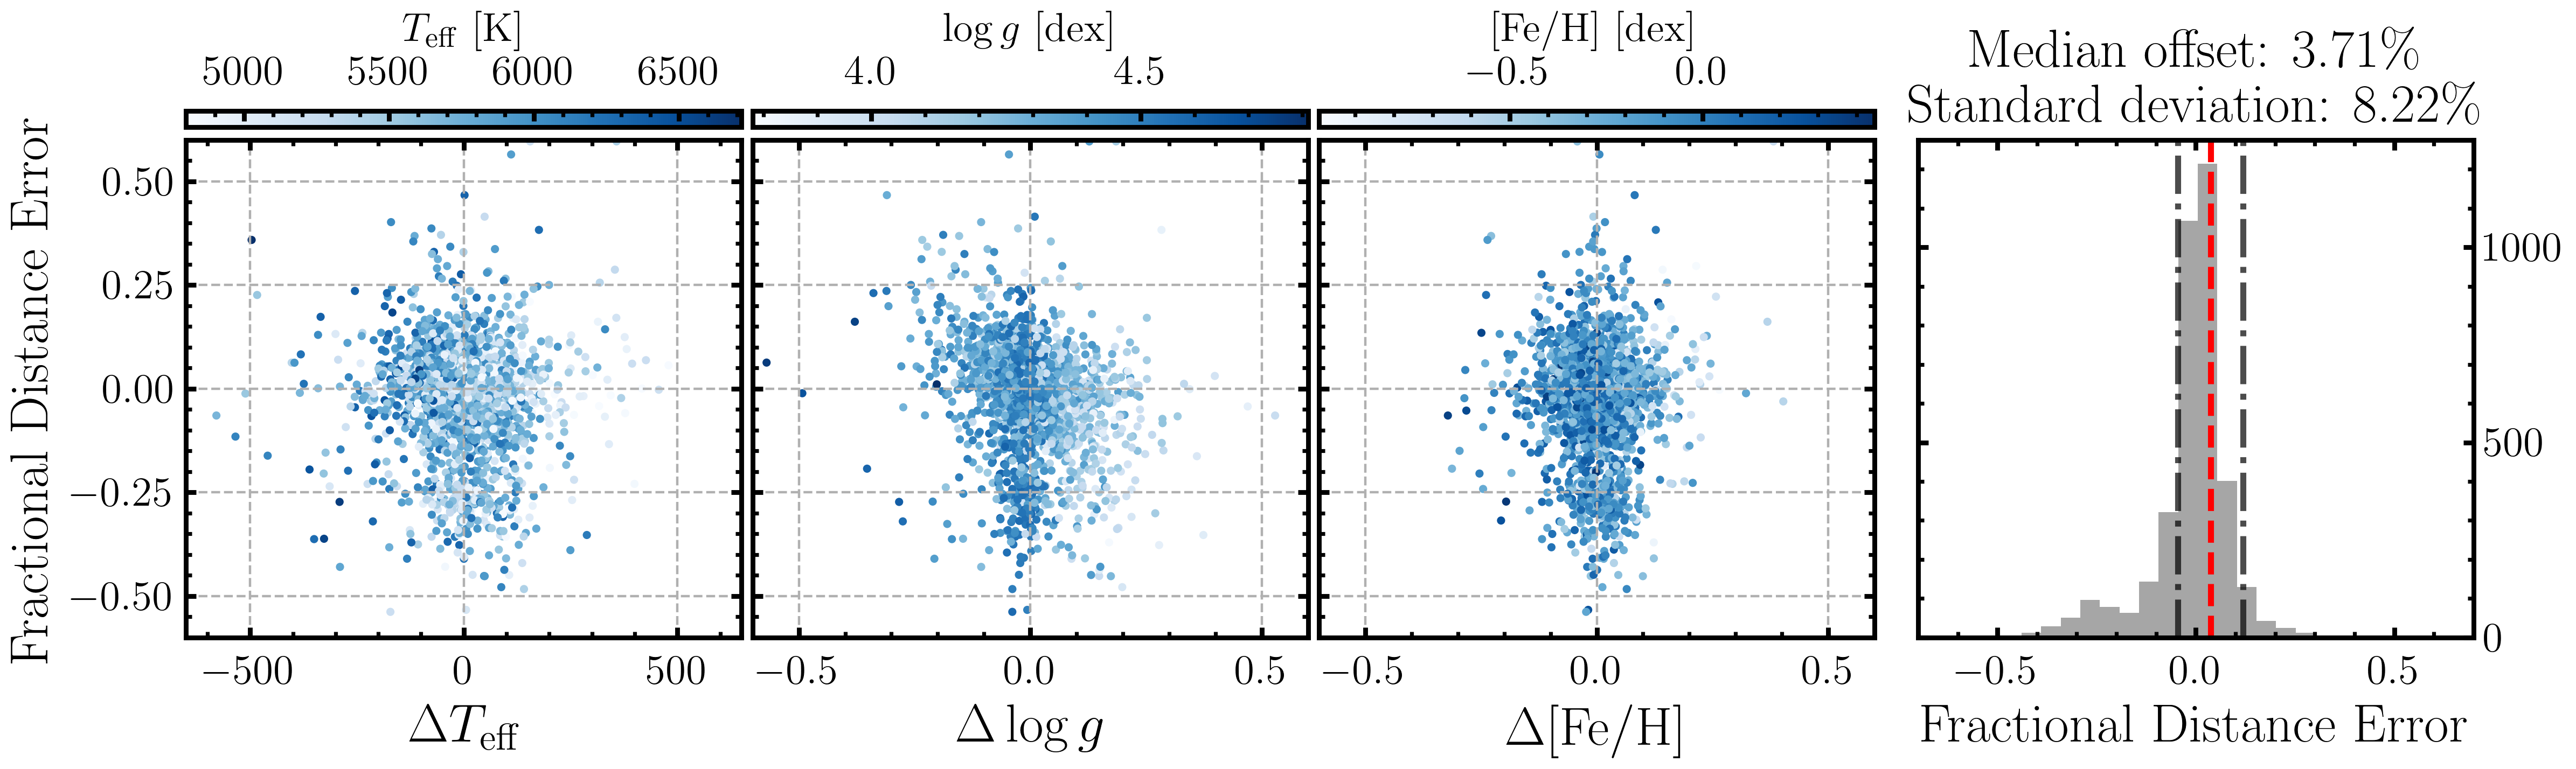

In [13]:
resid_logg = pre_logg - ori_logg
resid_teff = pre_teff - ori_teff
resid_feh = pre_feh - ori_feh

fig, ax = plt.subplots(1, 4, figsize=(13.5, 3), dpi=400)

plt.subplots_adjust(wspace=0.02)
f_d = (pre_d - ori_d) / ori_d

cmap = plt.cm.RdPu
cmap.set_bad(color='white')  # 设置空值颜色为白色
bins1d = 25

# ax0
x_ax0, y_ax0 = resid_teff, f_d
sc0 = ax[0].scatter(x_ax0, y_ax0, c=ori_teff, s=3, cmap='Blues')
cax0 = add_top_cax(ax[0], pad=0.02, width=0.025)
cbar0 = fig.colorbar(sc0, cax=cax0, location='top')
cbar0.ax.set_xlabel('$T_{\\rm{eff}}$' + ' [K]', fontsize=13.5, loc='center', labelpad=5)

# ax1
x_ax1, y_ax1 = resid_logg, f_d
sc1 = ax[1].scatter(x_ax1, y_ax1, c=ori_logg, s=3, cmap='Blues')
cax1 = add_top_cax(ax[1], pad=0.02, width=0.025)
cbar1 = fig.colorbar(sc1, cax=cax1, location='top')
cbar1.ax.set_xlabel('$\log{g}$' + ' [dex]', fontsize=13.5, loc='center', labelpad=5)


# ax2
x_ax2, y_ax2 = resid_feh, f_d
sc2 = ax[2].scatter(x_ax2, y_ax2, c=ori_feh, s=3, cmap='Blues')
cax2 = add_top_cax(ax[2], pad=0.02, width=0.025)
cbar2 = fig.colorbar(sc2, cax=cax2, location='top')
cbar2.ax.set_xlabel('[Fe/H]' + ' [dex]', fontsize=13.5, loc='center', labelpad=5)

ax[3].hist(f_d, bins=bins1d, histtype='bar', color='grey', alpha=0.7)  #

ax[0].set_xlim(-650, 650)
ax[1].set_xlim(-0.6, 0.6)
ax[2].set_xlim(-0.6, 0.6)

ax[0].set_ylim(-0.6, 0.6)
ax[1].set_ylim(-0.6, 0.6)
ax[2].set_ylim(-0.6, 0.6)

ax[0].set_xlabel('$\Delta T_{\\rm{eff}}$')
ax[1].set_xlabel('$\Delta \log{g}$')
ax[2].set_xlabel('$\Delta \\rm{[Fe/H]}$')
ax[3].set_xlabel('Fractional Distance Error')
ax[0].set_ylabel('Fractional Distance Error')

ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')
ax[2].grid(True, linestyle='--')

ax[1].set_yticklabels([])
ax[2].set_yticklabels([])


pos2 = ax[2].get_position()
ax[3].set_position([pos2.x1 + 0.015, pos2.y0, pos2.width, pos2.height])
ax[3].yaxis.tick_right()
ax[3].yaxis.set_ticks_position('both')
ax[3].set_xlim(-0.7, 0.7)

f_med_d = np.median(f_d)
f_mean_d = np.mean(f_d)
f_std_d = np.std(f_d)
f_med_abs_d = np.median(np.abs(f_d))

f2_d = np.abs(pre_d - ori_d) / ori_d
f2_mean_d = np.mean(f2_d)
f2_med_d = np.median(f2_d)
f2_std_d = np.std(f2_d)

ax[3].set_title(f'Median offset: {f2_med_d*100:.2f}\\%\n'
                f'Standard deviation: {f2_std_d*100:.2f}\\%', fontsize=18)
ax[3].axvline(x=f2_med_d, color='r', linestyle='--', linewidth=2)
ax[3].axvline(x=f2_med_d-f2_std_d, color='k', alpha=0.7, linestyle='-.', linewidth=2)
ax[3].axvline(x=f2_med_d+f2_std_d, color='k', alpha=0.7, linestyle='-.', linewidth=2)